In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
#def a function to reconstruct the image
import tensorflow as tf

imgs = []
lbls = []

def transform(row):
    image_array = np.reshape(row.iloc[1:].values, (28,28, 1))/255.
    np_image = np.array(image_array)
    tf_image = tf.convert_to_tensor(np_image)
    imgs.append(tf_image)
    lbls.append(row.iloc[0])

train.apply(transform, axis=1);

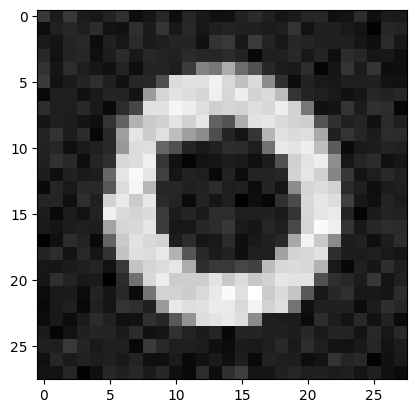

In [4]:
#adding noise to an image

def add_gaussian_noise(image, mean=0, std=25, factor=.5):
    return image+factor*np.random.normal(loc=mean, scale=std, size=image.shape)

noisy_image = add_gaussian_noise(imgs[1], mean=0.0, std=1.0, factor=.06)
plt.imshow(noisy_image, cmap='gray')

In [5]:
# adding noise to all images

noisy_images = list(map(lambda x: add_gaussian_noise(x, mean=0.0, std=1.0, factor=.04), imgs))

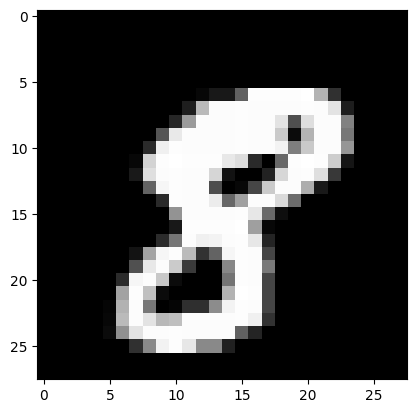

In [6]:
plt.imshow(imgs[10], cmap='gray')

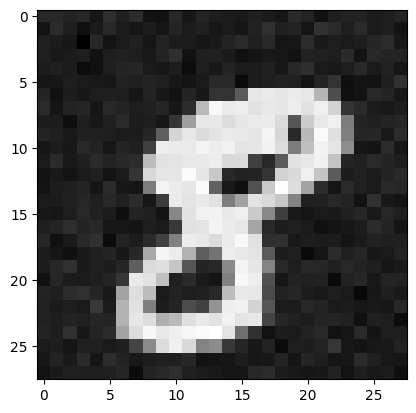

In [7]:
 plt.imshow(noisy_images[10], cmap='gray')

# make the dataset

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(noisy_images, imgs, test_size=.1)

In [9]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)) \
                          .batch(8) \
                          .cache() \
                          .prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)) \
                         .batch(8) \
                         .cache() \
                         .prefetch(tf.data.AUTOTUNE)

# modeling

In [10]:
#we have 2 main blocks conv and deconv block
import tensorflow.keras.layers as tfl

def conv_block(inputs, kernel_size=3, filters=16, dropout=False, max_pool=True):
    
    conv = tfl.Conv2D(filters, kernel_size, padding='same')(inputs)
    conv = tfl.Conv2D(filters, kernel_size, padding='same')(inputs)
    
    if dropout:
        conv = tfl.Dropout(.1)(conv)
    
    if max_pool:
        pool = tfl.MaxPooling2D()(conv)
    else:
        pool = conv
        
    return pool, conv

def deconv_block(inputs, residual, kernel_size=3, filters=16):
    
    out = tfl.Conv2DTranspose(filters, kernel_size, strides=2, padding='same')(inputs)
    conv = tfl.Concatenate()([out, residual])
    conv = tfl.Conv2D(filters, kernel_size, padding='same')(conv)
    conv = tfl.Conv2D(filters, kernel_size, padding='same')(conv)
    
    return conv

In [11]:
from tensorflow.keras import Model

inputs = tfl.Input(shape=(28,28,1))

x1 = conv_block(inputs, kernel_size=3, filters=16)
x2 = conv_block(x1[0], kernel_size=3, filters=16*2)

x3 = conv_block(x2[0], kernel_size=3, filters=16*4, dropout=True, max_pool=False)

d1 = deconv_block(x3[0], x2[1], kernel_size=3, filters=16*2)
d2 = deconv_block(d1, x1[1], kernel_size=3, filters=16)

conv = tfl.Conv2D(16, kernel_size=3, padding='same')(d2)
outputs = tfl.Conv2D(1, 1, activation='sigmoid', padding='same')(conv)

Encoder = Model(inputs=inputs, outputs=x3, name='encoder')

model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 28, 28, 16)   160         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 14, 14, 16)   0           ['conv2d_1[0][0]']               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 14, 14, 32)   4640        ['max_pooling2d[0][0]']          
                                                                                              

In [12]:
#lr on platue
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr = ReduceLROnPlateau(patience=1,
                       monitor='val_acc',
                       factor=0.5,
                       min_lr=0.00001)

In [13]:
model.compile(optimizer='adam', 
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

In [14]:
model.fit(train_ds, validation_data=test_ds, epochs=3, callbacks=[lr])

Epoch 1/3


2023-09-14 23:25:08.619465: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4725/4725 [==============================] - 46s 7ms/step - loss: 0.0658 - acc: 0.8151 - val_loss: 0.0639 - val_acc: 0.8155 - lr: 0.0010
Epoch 2/3
4725/4725 [==============================] - 33s 7ms/step - loss: 0.0633 - acc: 0.8152 - val_loss: 0.0635 - val_acc: 0.8155 - lr: 0.0010
Epoch 3/3
4725/4725 [==============================] - 33s 7ms/step - loss: 0.0628 - acc: 0.8152 - val_loss: 0.0630 - val_acc: 0.8155 - lr: 5.0000e-04


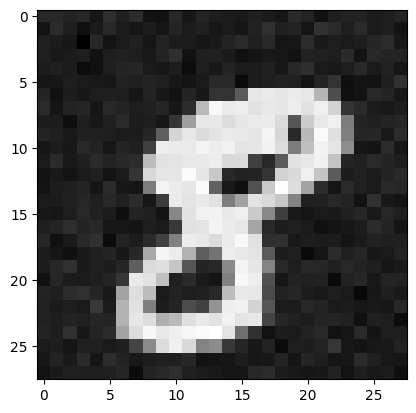

In [15]:
plt.imshow(noisy_images[10], cmap='gray')

In [16]:
test = model.predict(tf.expand_dims(noisy_images[100], 0))

1/1 [==============================] - 0s 383ms/step


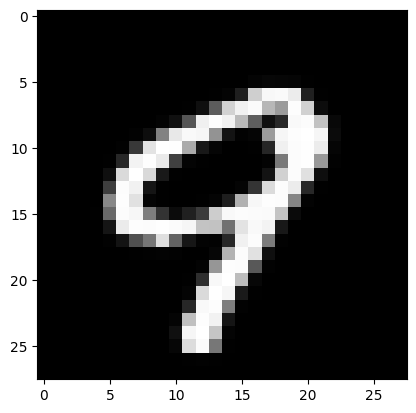

In [17]:
plt.imshow(tf.squeeze(test), cmap='gray')

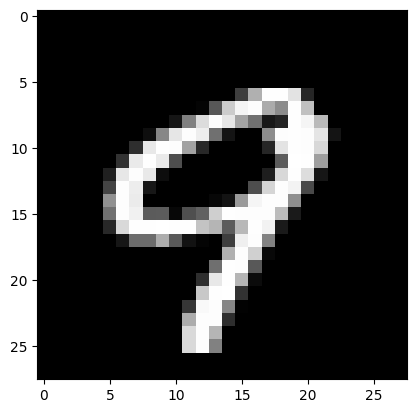

In [18]:
plt.imshow(imgs[100], cmap='gray')

In [19]:
model.save('/kaggle/working/keras_model')

In [27]:
from sklearn.model_selection import train_test_split

# x_train, x_test, y_train, y_test = train_test_split(imgs, lbls, test_size=.2)
# x_train = tf.stack(x_train)
# y_train = tf.convert_to_tensor(y_train)
# x_test = tf.stack(x_test)
# y_test = tf.convert_to_tensor(y_test)

x_train = tf.stack(imgs)
y_train = tf.convert_to_tensor(lbls)

In [28]:
train_class_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(16).prefetch(16)
# test_class_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(16).prefetch(16)

In [32]:
# building a classifier
from tensorflow.keras.models import Sequential

def block(units):
    return Sequential([
                tfl.Conv2D(units, 3, strides=(1,1), padding='same'),
                tfl.Conv2D(units, 3, strides=(1,1), padding='same'),
                tfl.Conv2D(units, 3, strides=(1,1), padding='same')
            ])

inputs = tfl.Input(shape=(28,28,1))
latent, _ = Encoder(inputs)
conv = block(128)(latent)
flatten = tfl.Flatten()(conv)
drop = tfl.Dropout(.2)(flatten)
outputs = tfl.Dense(10, activation='softmax')(drop)

classification_model = Model(inputs, outputs)
classification_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        ((None, 7, 7, 64),        23296     
                              (None, 7, 7, 64))                  
                                                                 
 sequential_3 (Sequential)   (None, 7, 7, 128)         369024    
                                                                 
 flatten_3 (Flatten)         (None, 6272)              0         
                                                                 
 dropout_3 (Dropout)         (None, 6272)              0         
                                                                 
 dense_3 (Dense)             (None, 10)                62730     
                                                           

In [37]:
classification_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='acc',
    factor=0.5,
    patience=1,
    min_lr=0.00001
)

In [38]:
classification_model.fit(train_class_ds,  
          epochs = 17,
          callbacks=[reduce_lr])

Epoch 1/17


2023-09-15 00:16:46.399870: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/encoder/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2625/2625 [==============================] - 16s 5ms/step - loss: 0.1444 - acc: 0.9663 - lr: 0.0010
Epoch 2/17
2625/2625 [==============================] - 13s 5ms/step - loss: 0.1382 - acc: 0.9665 - lr: 0.0010
Epoch 3/17
2625/2625 [==============================] - 14s 5ms/step - loss: 0.1429 - acc: 0.9656 - lr: 0.0010
Epoch 4/17
2625/2625 [==============================] - 13s 5ms/step - loss: 0.0572 - acc: 0.9829 - lr: 5.0000e-04
Epoch 5/17
2625/2625 [==============================] - 13s 5ms/step - loss: 0.0578 - acc: 0.9825 - lr: 5.0000e-04
Epoch 6/17
2625/2625 [==============================] - 13s 5ms/step - loss: 0.0309 - acc: 0.9902 - lr: 2.5000e-04
Epoch 7/17
2625/2625 [==============================] - 13s 5ms/step - loss: 0.0265 - acc: 0.9913 - lr: 2.5000e-04
Epoch 8/17
2625/2625 [==============================] - 13s 5ms/step - loss: 0.0257 - acc: 0.9919 - lr: 2.5000e-04
Epoch 9/17
2625/2625 [==============================] - 13s 5ms/step - loss: 0.0235 - acc: 0.9925 - lr:

In [39]:
tesst = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

tesst.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
ims = []

def transform(row):
    image_array = np.reshape(row.iloc[:].values, (28,28, 1))/255.
    np_image = np.array(image_array)
    tf_image = tf.convert_to_tensor(np_image)
    ims.append(tf_image)

tesst.apply(transform, axis=1);

In [54]:
t = tf.stack(ims)

In [56]:
prediction = classification_model.predict(t)

875/875 [==============================] - 2s 2ms/step


In [73]:
submissions = pd.DataFrame(columns=['ImageId', 'Label'])
submissions['ImageId'] = range(1, 28001)
submissions['Label'] = np.argmax(prediction, axis=1)

In [74]:
submissions.to_csv('/kaggle/working/keras_model/submissions2.csv', index=False)